In [25]:
import numpy as np
from scipy.spatial.distance import euclidean
import scipy
import torch

import dtw
import dtwalign
from fastdtw import fastdtw

from sklearn.manifold import TSNE
import pandas as pd

from src.speech_classification.audio_processing import AudioPreprocessorMFCCDeltaDelta, SpeechCommandsDataCollector
from src.siamese_net_sound_similarity.slstm_train import SiameseSpeechCommandsDataCollector, StochasticSiameseLSTMNet
from src.siamese_net_sound_similarity.train_v2 import SiameseDeepLSTMNet

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set(font_scale=1.4, rc={'text.usetex' : False})
sns.set_style("whitegrid")

%matplotlib inline

## Load data

In [26]:
wanted_words = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left'
                ]
# 'marvin',
#                 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two',
#                 'up', 'wow', 'yes', 'zero'

wanted_words_combined = wanted_words

model_settings = {
    'dct_coefficient_count': 13,
    'mfcc_num': 39,
    'label_count': len(wanted_words_combined) + 2,
    'hidden_reccurent_cells_count': 128,
    'winlen': 0.02,
    'winstep': 0.01
}

In [27]:
preproc = AudioPreprocessorMFCCDeltaDelta(numcep=model_settings['dct_coefficient_count'], winlen=model_settings['winlen'],
                                     winstep=model_settings['winstep'])

data_iter = SiameseSpeechCommandsDataCollector(preproc,
                                        data_dir=r'C:\Study\Speech_command_classification\speech_dataset',
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

index_to_word = {v:k for k,v in data_iter.word_to_index.items()}

# Gather Data for analysis

In [28]:
n_mini_batch_size = 4000

# gather data


data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])


In [29]:
# load nn

nn_fname = r'C:/Study/SpeechAcquisitionModel/reports/seamise_net_10_25_2019_01_55_PM/net_0.4609375.net'

nn = torch.load(nn_fname).cpu()

In [30]:
nn_input = torch.from_numpy(data['x']).float()

In [31]:
z, *_ = nn.single_forward(nn_input)
z = z.detach().cpu().numpy()

duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).float())
duplicates_z = duplicates_z.detach().cpu().numpy()

non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).float())
non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

## Visuialize embedding space with t-SNE

### Whole sequence (visualize trajectories in the embedding space)

In [32]:
# whole_dataset = np.concatenate([z, duplicates_z, non_duplicates_z])
whole_dataset = z
whole_dataset = whole_dataset[:, -1, :].squeeze()
print(whole_dataset.shape)

(4000, 32)


In [33]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(whole_dataset)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.008s...
[t-SNE] Computed neighbors for 4000 samples in 0.316s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 2.122948
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.393719
[t-SNE] Error after 300 iterations: 1.375341


In [34]:
labels_words = []
for i in range(len(labels)):
    labels_words.extend([index_to_word[labels[i]]])
df = pd.DataFrame({'t-SNE 1-st component' : tsne_results[:, 0],
't-SNE 2-nd component' : tsne_results[:, 1],
'word': labels_words})

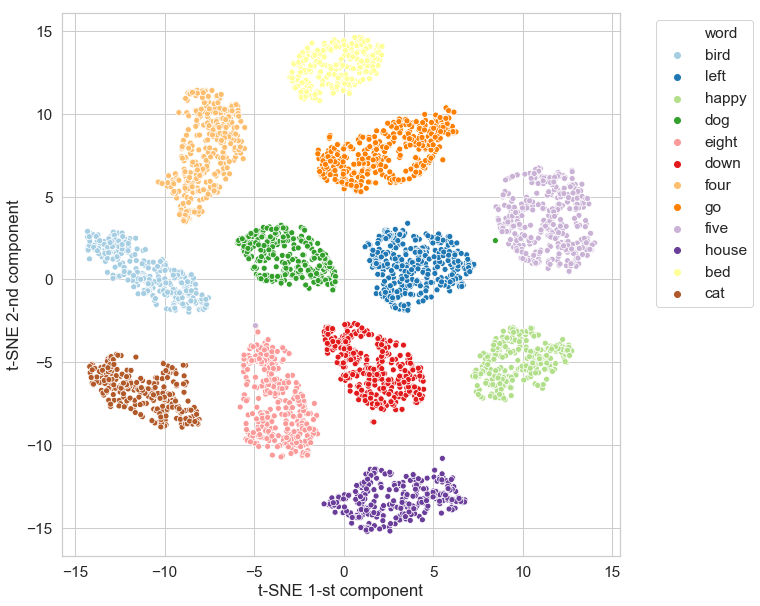

In [35]:
%matplotlib inline
plt.figure(figsize=(10,10))
my_palette = sns.color_palette("Paired", len(wanted_words))
ax = sns.scatterplot(x='t-SNE 1-st component', y='t-SNE 2-nd component', hue='word', data=df, palette=my_palette)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)